In [1]:
import pandas as pd
pd.set_option('float_format', '{:.6f}'.format)
pd.options.mode.chained_assignment = None

from prince import MCA

import numpy as np
np.random.RandomState(seed=42)

import matplotlib.pyplot as plt

import xgboost as xgb

from os.path import isfile
import pickle
import lzma

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, silhouette_score
from sklearn.preprocessing import StandardScaler, scale, LabelEncoder
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import MissingIndicator

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

from imblearn.under_sampling import InstanceHardnessThreshold 
from imblearn.over_sampling import SMOTE


import seaborn as sns

from pyclustertend import hopkins, vat

import missingno as msno

from scipy.stats import yeojohnson

import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

In [2]:
def make_experiment(experiment_number: int, dataset: pd.DataFrame):
    
    X = dataset.drop(['isFraud'], axis=1)
    y = dataset[['isFraud']]

    experiment_cv_scoes = list()

    score_file_name = "./data/models/rf_test_" + str(experiment_number) + ".xz"
    cluster_tendency_file_name = "./data/models/c_tendency_" + str(experiment_number) + ".xz"

    print("Experiment #{}:".format(experiment_number))

    if isfile(score_file_name):
        with lzma.open(score_file_name, "rb") as m_file:
            experiment_cv_scoes = pickle.load(m_file)
            print("\tCV scores loaded.")
    else:
        print("\tNo CV scores, calculating.")
        clf = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)

        experiment_cv_scoes = cross_val_score(estimator=clf, X=X, y=y.to_numpy().flatten(), cv=5, scoring='roc_auc')
            
        with lzma.open(score_file_name, "wb") as m_file:
            pickle.dump(experiment_cv_scoes, m_file)
            print("\tCV scores saved.")


    experiment_cluster_tendency = -1.0

    if isfile(cluster_tendency_file_name):
        with lzma.open(cluster_tendency_file_name, "rb") as m_file:
            experiment_cluster_tendency = pickle.load(m_file)
            print("\tHopkins score loaded.")
    else:
        print("\tNo Hopkins score, calculating.")
        experiment_cluster_tendency = hopkins(dataset.drop(['isFraud'], axis=1), dataset.shape[0])
        
        with lzma.open(cluster_tendency_file_name, "wb") as m_file:
            pickle.dump(experiment_cluster_tendency, m_file)
            print("\tHopkins score saved.")

    print("\n\tCV scores are: {}\n\tMean score is: {}\n\tHopkins score is: {}".format(experiment_cv_scoes, experiment_cv_scoes.mean(), experiment_cluster_tendency))

    return experiment_cv_scoes, experiment_cluster_tendency


**Импорт данных**

In [3]:
transactions_src_df = pd.read_csv(filepath_or_buffer='./data/trans_small.csv')
identity_src_df = pd.read_csv(filepath_or_buffer='./data/identity_small.csv')

**Объединение датасетов**

Присоединю к датасету trans_small identity_small. В прошлой работе я сделал наоборот и потерял часть важной информации - isFraud=1.

In [4]:
merged_df = transactions_src_df.merge(right = identity_src_df, on='TransactionID', how='left')
merged_df.drop(['TransactionID', 'D4.1'], axis=1, inplace=True)

**Категоризация**

Тут обычный LabelEncoder.

In [5]:
m5_le = LabelEncoder()
merged_df['M5'] = m5_le.fit_transform(y=merged_df[['M5']].fillna('NaN'))

nan_index = m5_le.classes_.tolist().index('NaN')
nan_category_value = m5_le.transform(m5_le.classes_)[nan_index]

merged_df['M5'] = [np.NaN if x == nan_category_value else x for x in merged_df['M5']]

c:\program files\python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [6]:
id_29_le = LabelEncoder()
merged_df['id_29'] = id_29_le.fit_transform(y=merged_df[['id_29']].fillna('NaN'))

nan_index = id_29_le.classes_.tolist().index('NaN')
nan_category_value = id_29_le.transform(id_29_le.classes_)[nan_index]

merged_df['id_29'] = [np.NaN if x == nan_category_value else x for x in merged_df['id_29']]

In [7]:
id_33_le = LabelEncoder()
merged_df['id_33'] = id_33_le.fit_transform(y=merged_df[['id_33']].fillna('NaN'))

nan_index = id_33_le.classes_.tolist().index('NaN')
nan_category_value = id_33_le.transform(id_33_le.classes_)[nan_index]

merged_df['id_33'] = [np.NaN if x == nan_category_value else x for x in merged_df['id_33']]

**Анализ отсутствующих значений**

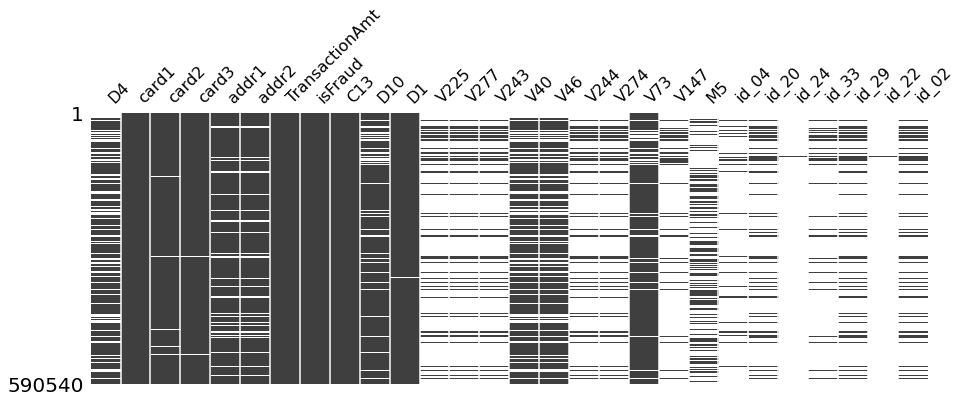

In [8]:
figure, ax = plt.subplots( figsize=(15, 5))
msno.matrix(merged_df, ax=ax, sparkline=False)
plt.show()

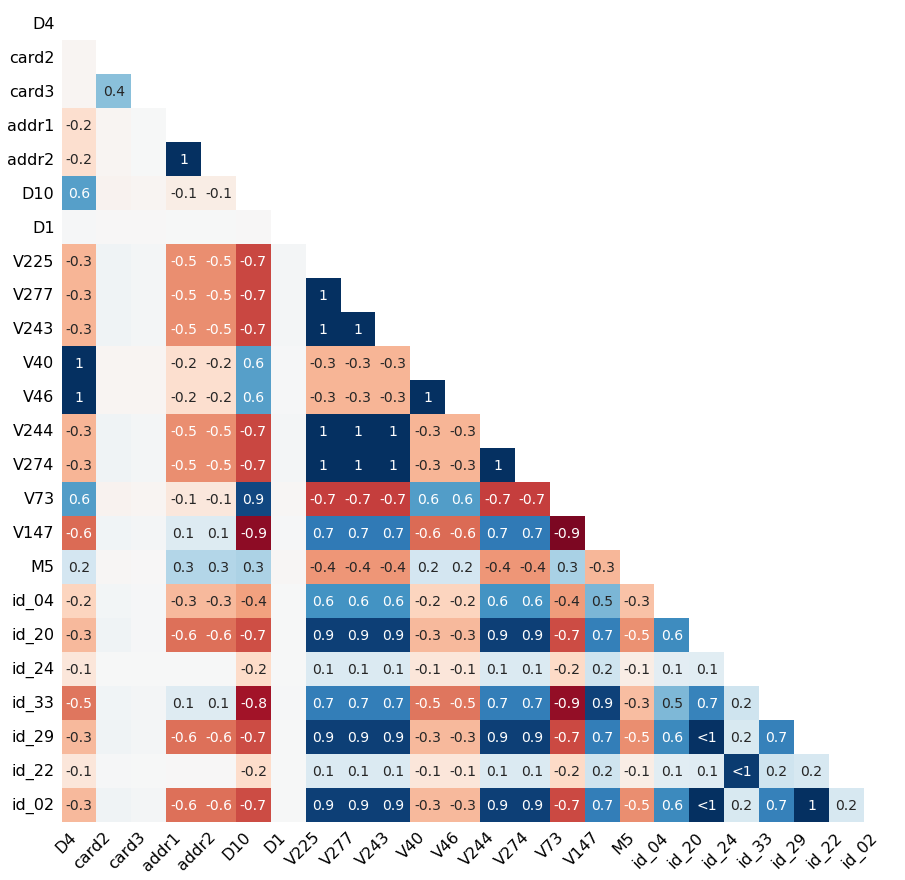

In [9]:
msno.heatmap(merged_df, figsize=(15, 15), cbar=False)
plt.show()

<AxesSubplot:>

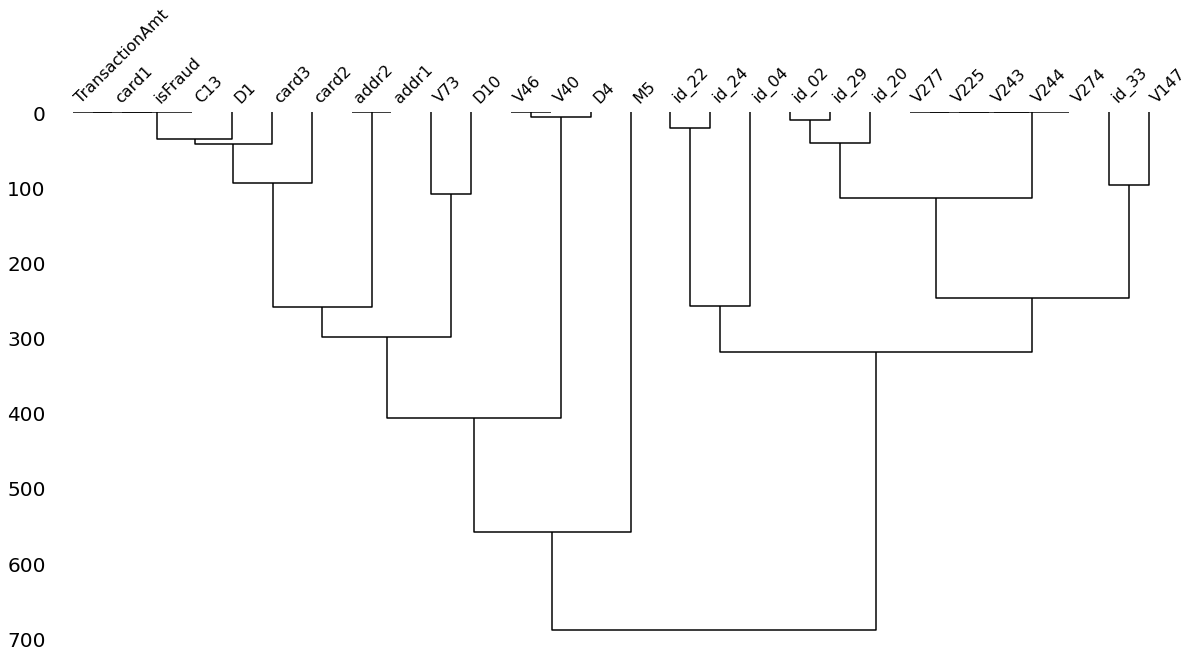

In [10]:
msno.dendrogram(merged_df, figsize=(20, 10))

Отсутствие данных, что интересно, имеет довольно сильную взаимосвязь. По сути, связь отсутствия выше корреляци.

**Анализ дискретности предикторов**

In [11]:
cols_int_check = {}

for col in merged_df.columns:
    current_series = np.array([(x - round(x)) for x in merged_df[col].loc[~merged_df[col].isna()]])
    
    series_data = []

    if current_series.sum() == 0:
        series_data.append(True)
    else:
        series_data.append(False)

    unique_in_series = sorted(np.unique(merged_df[col].loc[~merged_df[col].isna()]))

    series_data.append(len(unique_in_series))

    may_be_category = False

    for idx, value in enumerate(unique_in_series[:-1:]):
        if (value + 1) == unique_in_series[idx + 1] and value >= 0:
            may_be_category = True
        else:
            may_be_category = False

    series_data.append(may_be_category)

    cols_int_check[col] = series_data

cols_int_check['id_33'][2] = True
cols_int_check['id_29'][2] = True
cols_int_check['M5'][2] = True

In [12]:
pd.DataFrame(cols_int_check, index=['isInt', 'unique values', 'may be category']).T

,isInt,unique values,may be category
D4,True,808,False
card1,True,13553,True
card2,True,500,True
card3,True,114,False
addr1,True,332,False
addr2,True,74,True
TransactionAmt,False,20902,False
isFraud,True,2,True
C13,True,1597,True
D10,True,818,False


Данные, приемущественно, дискретные. Уникальных значений крайне мало. И я решил проверить, а не с категориями ли я имею дело.

Проверку провел самым простым способом. Если в отсортированном массиве уникальных значений следующее от предыдущего отличается на единицу, то у меня появляется основание заподозрить предиктор в категориальности.

Оказалось, что половина датасета может быть категориями. 

**Сохранение информации о NaN**

In [13]:
missing_indicator = MissingIndicator(features='all', sparse=False)

merged_df_impute_info = missing_indicator.fit_transform(merged_df.drop(['isFraud'], axis=1)).astype('float')

nan_info_cols = [x + '_imp' for x in merged_df.drop(['isFraud'], axis=1).columns.values]

merged_nan_info_df = pd.DataFrame(data=merged_df_impute_info, columns=nan_info_cols)

**Multivariate imputation**

Для начала примению Multivariate imputation и не буду импутировать предикторы по отдельности. Никакие. 

In [14]:
merged_imputed_df = pd.DataFrame()

if isfile("./data/merged_imputed_df.csv"):
    merged_imputed_df = pd.read_csv(filepath_or_buffer='./data/merged_imputed_df.csv', compression='xz')
else:
    imputer = MissForest(max_iter=10, random_state=42, verbose=0)
    
    df_imputed = imputer.fit_transform(merged_df.drop(['isFraud'], axis=1))
    merged_imputed_df = pd.DataFrame(data=df_imputed, columns=merged_df.drop(['isFraud'], axis=1).columns.values).join(merged_df[['isFraud']])
    
    merged_imputed_df.to_csv(path_or_buf='./data/merged_imputed_df.csv', compression='xz')

In [15]:
merged_imputed_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [16]:
for col in cols_int_check:
    if cols_int_check[col][0]:
        merged_imputed_df[col] = merged_imputed_df[col].map(round)

In [17]:
cols_int_check_imputed = {}

for col in merged_imputed_df.columns:
    current_series = np.array([(x - round(x)) for x in merged_imputed_df[col].loc[~merged_imputed_df[col].isna()]])
    
    series_data = []

    if current_series.sum() == 0:
        series_data.append(True)
    else:
        series_data.append(False)

    unique_in_series = sorted(np.unique(merged_imputed_df[col].loc[~merged_imputed_df[col].isna()]))

    series_data.append(len(unique_in_series))

    may_be_category = False

    for idx, value in enumerate(unique_in_series[:-1:]):
        if (value + 1) == unique_in_series[idx + 1] and value >= 0:
            may_be_category = True
        else:
            may_be_category = False

    series_data.append(may_be_category)

    cols_int_check_imputed[col] = series_data

In [18]:
summary_cols_info = {}

for col in cols_int_check_imputed:
    summary_data = []
    for i in range(3):
        summary_data.append(cols_int_check[col][i])
        summary_data.append(cols_int_check_imputed[col][i])
    
    summary_cols_info[col] = summary_data

In [19]:
pd.DataFrame(summary_cols_info, index=['isInt', 'isInt imp', 'unique values', 'unique values imp', 'may be category', 'may be category imp']).T

,isInt,isInt imp,unique values,unique values imp,may be category,may be category imp
D4,True,True,808,821,False,False
card1,True,True,13553,13553,True,True
card2,True,True,500,500,True,True
card3,True,True,114,120,False,False
addr1,True,True,332,421,False,False
addr2,True,True,74,90,True,True
TransactionAmt,False,False,20902,20902,False,False
C13,True,True,1597,1597,True,True
D10,True,True,818,819,False,False
D1,True,True,641,641,True,True


In [20]:
imputed_cv_scores, imputed_cl_tend = make_experiment(1, merged_imputed_df)

Experiment #1:
	CV scores loaded.
	Hopkins score loaded.

	CV scores are: [0.83922133 0.87645663 0.87078225 0.88899096 0.85439068]
	Mean score is: 0.8659683697427057
	Hopkins score is: 0.005566843144842202


Получилось интересно. Количество уникальных значений в предпологаемых категорях не выросло практически. 

Попробую теперь имутировать категориальные предикторы отдельно.

**ffill + multivariate imputation**

In [21]:
merged_imputed_ff_df = pd.DataFrame()

if isfile("./data/merged_imputed_ff_df.csv"):
    merged_imputed_ff_df = pd.read_csv(filepath_or_buffer='./data/merged_imputed_ff_df.csv', compression='xz')
else:
    temp_df = pd.DataFrame()

    imputer = MissForest(max_iter=10, random_state=42, verbose=0)
    
    for col in cols_int_check:
        if cols_int_check[col][2]:
            temp_df[col] = merged_df[[col]].fillna(method='ffill')
            temp_df[col] = temp_df[col].fillna(method='bfill')
        else:
            temp_df[col] = merged_df[col]

    df_imputed = imputer.fit_transform(temp_df.drop(['isFraud'], axis=1))
    merged_imputed_ff_df = pd.DataFrame(data=df_imputed, columns=merged_df.drop(['isFraud'], axis=1).columns.values).join(merged_df[['isFraud']])
    
    merged_imputed_ff_df.to_csv(path_or_buf='./data/merged_imputed_ff_df.csv', compression='xz')

In [22]:
merged_imputed_ff_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [23]:
mca_cols = list()

for col in cols_int_check:
    if cols_int_check[col][0]:
        merged_imputed_ff_df[col] = merged_imputed_ff_df[col].map(round)
        if merged_imputed_ff_df[col].min() >= 0:
            mca_cols.append(col)

In [24]:
a, b = make_experiment(2, merged_imputed_ff_df)

Experiment #2:
	CV scores loaded.
	Hopkins score loaded.

	CV scores are: [0.82257215 0.85902104 0.8548487  0.8713984  0.84420271]
	Mean score is: 0.8504085979269916
	Hopkins score is: 0.0077438716039541534


Попробую сравнить распределения для обоих вариантов.

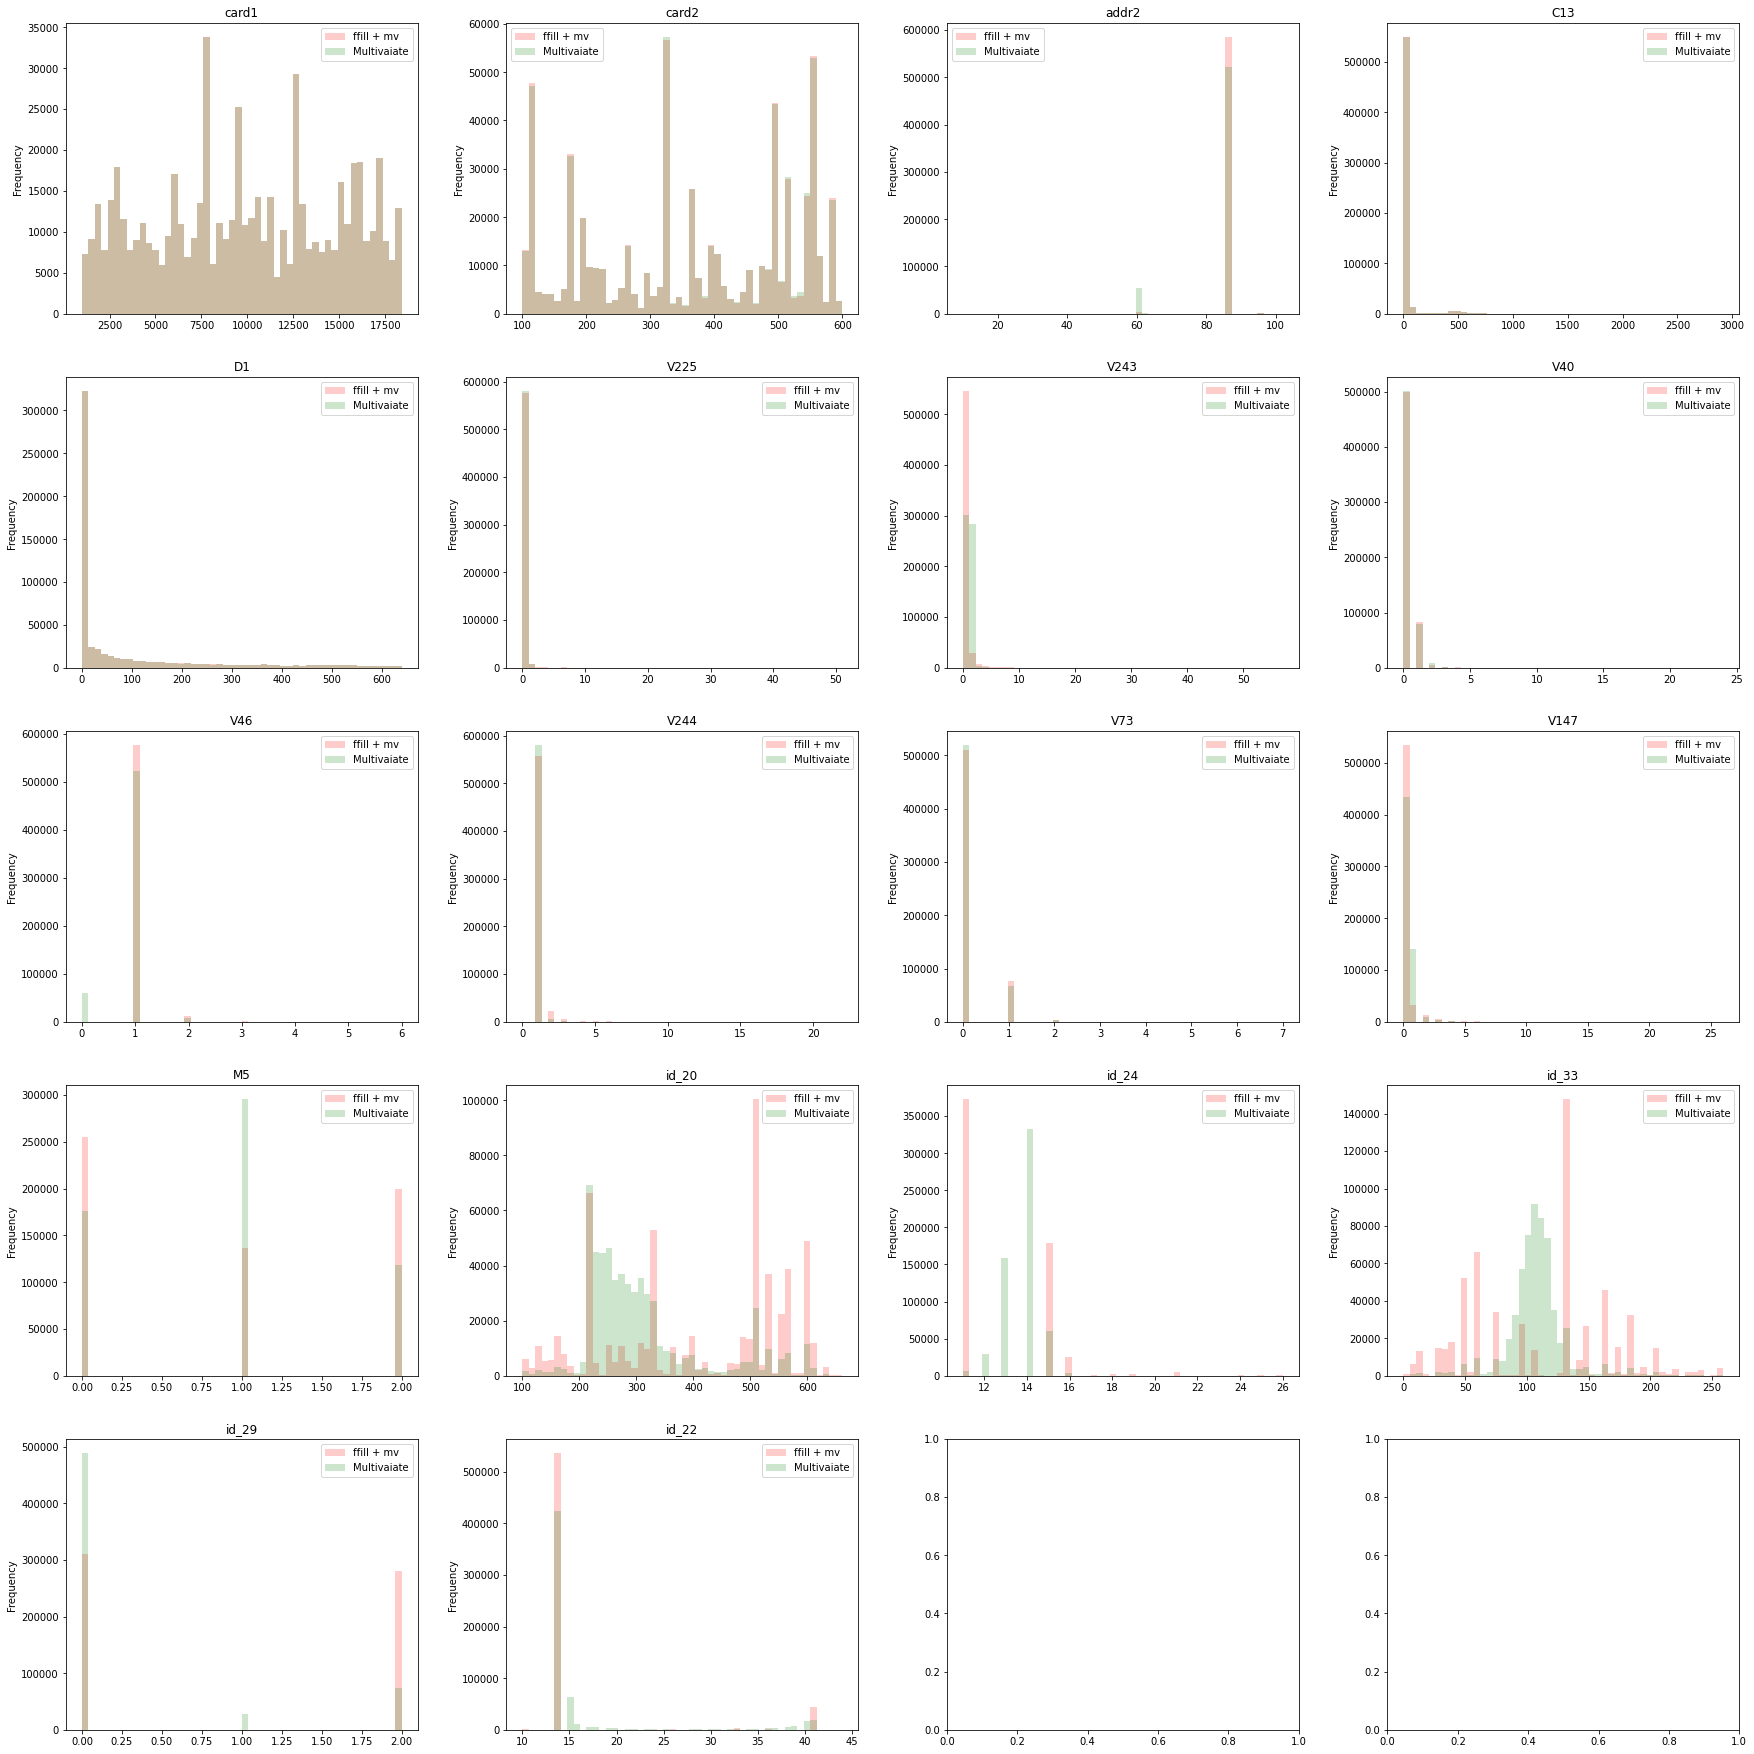

In [25]:
figure, ax = plt.subplots(5, 4, figsize=(25, 25))
axs = ax.flatten()

idx = 0
cat_cols = []

for col in cols_int_check:
    if cols_int_check[col][2] and col != 'isFraud':
        merged_imputed_ff_df[col].plot.hist(ax=axs[idx], color='red', bins=50, alpha=0.2)
        merged_imputed_df[col].plot.hist(ax=axs[idx], color='green', bins=50, alpha=0.2)
        axs[idx].set_title(col)
        axs[idx].legend(['ffill + mv', 'Multivaiate'])
        cat_cols.append(col)
        idx += 1
        
figure.tight_layout(pad=3.0)
plt.show()

Сложно сказать, какой из двух вариантов предпочтителен. Но ffill + mv имеет большее число Хопкинса и не создает лишних категорий там, где я точно знаю их количество. Попробую поработать с этим вариантом.

**Sampling**

Применю комбинацию over + under sampling. SMOTE для oversampling и InstanceHardnessThreshold для undersampling.

In [26]:
sampled_df = pd.DataFrame()

if isfile("./data/sampled_df.xz"):
    with lzma.open("./data/sampled_df.xz", "rb") as m_file:
        sampled_df = pickle.load(m_file)
else:
    sampled_df = merged_imputed_ff_df.drop(['isFraud'], axis=1).join(merged_nan_info_df)

    smote_worker = SMOTE(random_state=42, n_jobs=-1, sampling_strategy=0.25)
    iht_worker = InstanceHardnessThreshold(random_state=42, n_jobs=-1, sampling_strategy=1.0)

    sampled_data, sampled_class = smote_worker.fit_resample(sampled_df, merged_df[['isFraud']])
    
    sampled_data_df = pd.DataFrame(data=sampled_data, columns=sampled_df.columns.values)
    sampled_class_df = pd.DataFrame(data=sampled_class, columns=['isFraud'])
    
    sampled_data, sampled_class = iht_worker.fit_resample(sampled_data_df, sampled_class_df)

    sampled_data_df = pd.DataFrame(data=sampled_data, columns=sampled_df.columns.values)
    sampled_class_df = pd.DataFrame(data=sampled_class, columns=['isFraud'])
    
    sampled_df = sampled_data_df.join(sampled_class_df)
    
    with lzma.open("./data/sampled_df.xz", "wb") as m_file:
        pickle.dump(sampled_df, m_file)



In [27]:
a, b = make_experiment(3, sampled_df)

Experiment #3:
	CV scores loaded.
	Hopkins score loaded.

	CV scores are: [0.98181688 0.99976799 0.99978729 0.99973887 0.99928445]
	Mean score is: 0.996079094459741
	Hopkins score is: 0.007886963200206988


Ничего себе эффект... Выраженность кластеров не особо выросла, а вот ROC-AUC прямо взлетел. Но это не удивительно, поскольку были выброшены самые сложные для предсказания строки. Для классификации это недопустимо, а вот для кластеризации очень может быть хорошо.

**Multiple correspondence analysis**

In [28]:
mca_worker = MCA(n_components=2, n_iter=10, copy=True, check_input=True, engine='auto', random_state=42)

mca_nan_values = mca_worker.fit_transform(sampled_df[nan_info_cols].drop(['card1_imp', 'TransactionAmt_imp', 'C13_imp'], axis=1))
mca_discrete_values = mca_worker.fit_transform(sampled_df[mca_cols])

In [29]:
mca_discrete_values_df = pd.DataFrame(data=mca_discrete_values.values, columns=['MCA_D_1', 'MCA_D_2'])
mca_nan_values_df = pd.DataFrame(data=mca_nan_values.values, columns=['MCA_NAN_1', 'MCA_NAN_2'])

In [30]:
mca_df = sampled_df.drop(np.concatenate((nan_info_cols, mca_cols)) , axis=1)
mca_df = mca_df.join(mca_discrete_values_df)
mca_df = mca_df.join(mca_nan_values_df)
mca_df = mca_df.join(sampled_df[['isFraud']])
mca_df.T

,0,1,2,3,4,5,6,7,8,9,...,301150,301151,301152,301153,301154,301155,301156,301157,301158,301159
D4,0.000000,94.000000,0.000000,0.000000,0.000000,107.000000,45.000000,8.000000,0.000000,358.000000,...,28.000000,167.000000,0.000000,142.000000,42.000000,177.000000,244.000000,372.000000,30.000000,459.000000
TransactionAmt,59.000000,50.000000,49.000000,159.000000,15.000000,50.000000,40.000000,100.000000,47.950000,159.950000,...,274.179340,68.723139,87.274325,358.605055,350.000000,211.919322,86.266457,74.785320,92.631610,222.546484
V277,18.063396,50.509389,8.384139,0.000000,0.000000,4.080924,32.965745,0.000000,0.000000,19.750000,...,394.737672,1.950366,0.000000,5101.242988,194.368224,52.207681,165.204623,0.000000,3.052674,145.776292
V274,325.258483,32.645258,228.665048,394.109976,0.000000,769.197563,20.989151,0.000000,0.476714,30.000000,...,42.449081,44.464944,2525.365295,16509.555189,174.306161,508.270021,181.363007,149.079943,193.386239,189.393012
id_04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MCA_D_1,-0.065913,0.120225,0.023691,0.072352,-0.105308,-0.099801,0.172011,0.453928,-0.010435,0.045846,...,0.057842,0.220980,-0.162339,0.104616,-0.180310,0.114460,0.588232,1.288959,-0.078667,0.118185
MCA_D_2,-0.005282,-0.032047,-0.016948,-0.054979,0.007350,0.040372,-0.037950,-0.102187,0.000607,0.189525,...,-0.041171,-0.048814,-0.008768,-0.007262,0.008946,-0.051312,-0.048834,0.124223,-0.020429,0.127698
MCA_NAN_1,-0.466885,-0.466885,-0.466885,-0.466885,1.613784,-0.466885,-0.385532,1.835309,-0.385532,-0.385532,...,-0.466885,-0.203367,0.586621,-0.320463,0.836438,0.119601,0.494477,1.365020,-0.466885,-0.422288
MCA_NAN_2,-0.198080,-0.198080,-0.198080,-0.198080,-0.367085,-0.198080,-0.133413,-0.394193,-0.133413,-0.133413,...,-0.198080,0.189510,1.351448,-0.242997,-0.253022,0.803604,-0.296580,-0.148172,-0.198080,-0.211761
isFraud,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
a, b = make_experiment(4, mca_df)

Experiment #4:
	CV scores loaded.
	Hopkins score loaded.

	CV scores are: [0.95081327 0.99799057 0.99804511 0.99798313 0.99446654]
	Mean score is: 0.9878597254379955
	Hopkins score is: 0.0005355021643401768


In [32]:
mca_scaled_values = StandardScaler().fit_transform(mca_df.drop(['isFraud'], axis=1))
mca_scaled_df = pd.DataFrame(data=mca_scaled_values, columns=mca_df.drop(['isFraud'], axis=1).columns.values)
mca_scaled_df = mca_scaled_df.join(mca_df[['isFraud']])

In [33]:
a, b = make_experiment(5, mca_scaled_df)

Experiment #5:
	CV scores loaded.
	Hopkins score loaded.

	CV scores are: [0.95078904 0.99798901 0.99800667 0.99803394 0.99423885]
	Mean score is: 0.9878115023231328
	Hopkins score is: 0.0018436595211907233


В принципе, MCA разработан как раз для ниелинейного преобразования дискретных предикторов. Но я не проводил никакого анализа, сколько нужно оставлять предикторов. 2 это нипочему, на самом деле.

**KMeans**

In [34]:
kmeans_estimators = list()
k_list = [2, 5, 10, 20, 50, 100, 250, 600]

if isfile("./data/models/kmeans.xz"):
    with lzma.open("./data/models/kmeans.xz", "rb") as m_file:
        kmeans_estimators = pickle.load(m_file)
else:
    for k in k_list:
        worker = KMeans(random_state=42, n_clusters=k)
        worker.fit(mca_scaled_df.drop(['isFraud'], axis=1))
        kmeans_estimators.append(worker)
        print("N {} proceed.".format(k))

    with lzma.open("./data/models/kmeans.xz", "wb") as m_file:
        pickle.dump(kmeans_estimators, m_file)


In [35]:
X = mca_scaled_df.drop(['isFraud'], axis=1)
kmeans_scores = list()

if isfile("./data/models/kmeans_scores.xz"):
    with lzma.open("./data/models/kmeans_scores.xz", "rb") as m_file:
        kmeans_scores = pickle.load(m_file)
else:
    
    for estimator in kmeans_estimators:
        print("Calculating Silhouette score for N {}".format(estimator.n_clusters))
        score = silhouette_score(X, estimator.labels_, metric = 'euclidean')
        kmeans_scores.append(score)
        print("Done.")

    with lzma.open("./data/models/kmeans_scores.xz", "wb") as m_file:
        pickle.dump(kmeans_scores, m_file)

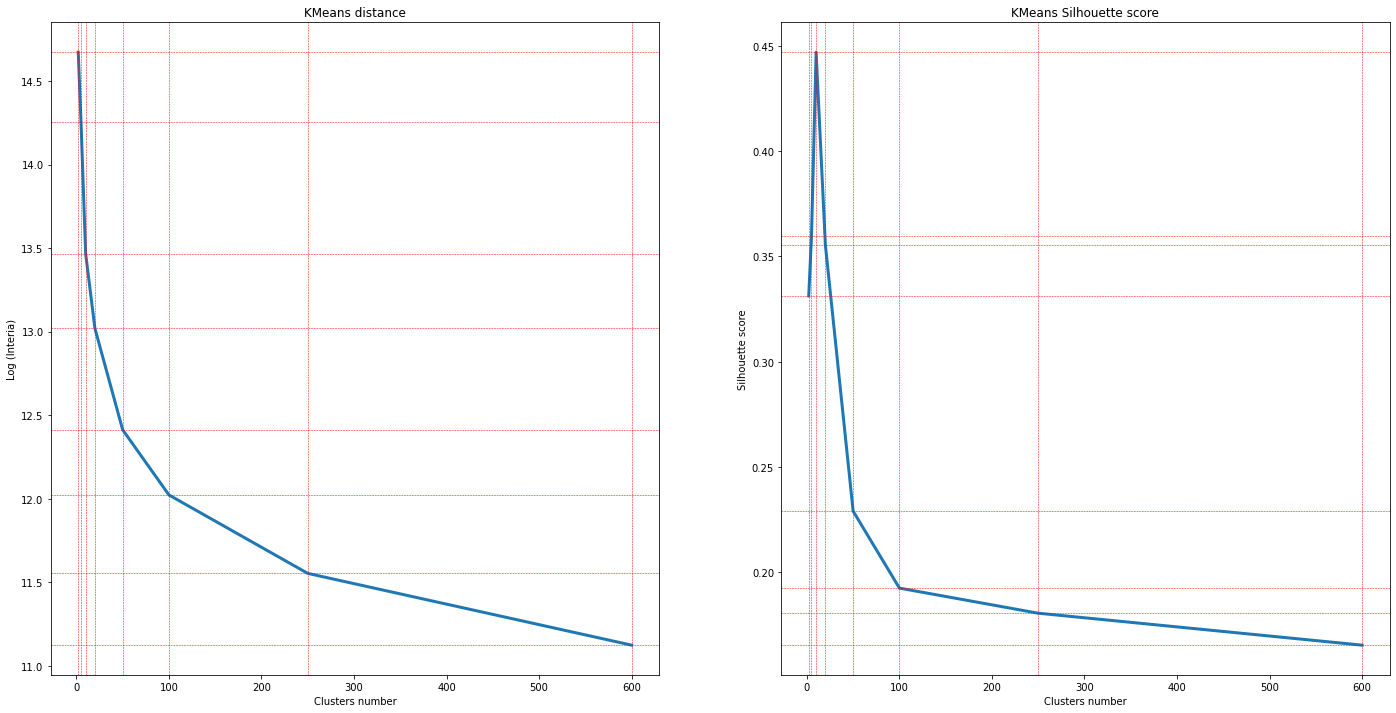

In [36]:
x = list()
y = list()

for estimator in kmeans_estimators:
    x.append(estimator.n_clusters)
    y.append(np.log(estimator.inertia_))

figure, axis = plt.subplots(1, 2, figsize=(24, 12))
axs = axis.flatten()

axs[0].plot(x, y, linewidth=3)
axs[0].set_title("KMeans distance")
axs[0].set_xlabel("Clusters number")
axs[0].set_ylabel("Log (Interia)")

axs[1].plot(x, kmeans_scores, linewidth=3)
axs[1].set_title("KMeans Silhouette score")
axs[1].set_xlabel("Clusters number")
axs[1].set_ylabel("Silhouette score")

for idx, k in enumerate(k_list):
    axs[0].axvline(x=k, color='red', linestyle='--', linewidth=0.5)
    axs[0].axhline(y=y[idx],color='red', linestyle='--', linewidth=0.5)
    axs[1].axvline(x=k, color='red', linestyle='--', linewidth=0.5)
    axs[1].axhline(y=kmeans_scores[idx], color='red', linestyle='--', linewidth=0.5)

#plt.savefig(fname="./data/img/scores_1.svg", dpi=150)
plt.show()

In [37]:
pd.DataFrame(data=[k_list, kmeans_scores])

,0,1,2,3,4,5,6,7
0,2.000000,5.000000,10.000000,20.000000,50.000000,100.000000,250.000000,600.000000
1,0.331277,0.359559,0.447012,0.355433,0.229097,0.192561,0.180646,0.165483


Картина не очень понятная. Силуэт и elbow показывают несколко разные результаты. Elbow показывает 50-100 кластеров, силуэт явно 10. Попробую оба.

In [38]:
elbow_clusters = None

if isfile("./data/models/elbow_clusters.xz"):
    with lzma.open("./data/models/elbow_clusters.xz", "rb") as m_file:
        elbow_clusters = pickle.load(m_file)
else:
    elbow_clusters = KMeans(random_state=42, n_clusters=75).fit_predict(X)

    with lzma.open("./data/models/elbow_clusters.xz", "wb") as m_file:
        pickle.dump(elbow_clusters, m_file)



In [39]:
silhouette_clusters = None

if isfile("./data/models/silhouette_clusters.xz"):
    with lzma.open("./data/models/silhouette_clusters.xz", "rb") as m_file:
        silhouette_clusters = pickle.load(m_file)
else:
    silhouette_clusters = KMeans(random_state=42, n_clusters=10).fit_predict(X)

    with lzma.open("./data/models/silhouette_clusters.xz", "wb") as m_file:
        pickle.dump(silhouette_clusters, m_file)

In [40]:
clustered_df = pd.DataFrame(data=X)
clustered_df = clustered_df.join(pd.DataFrame(data=elbow_clusters, columns=['elbow']))
clustered_df = clustered_df.join(pd.DataFrame(data=silhouette_clusters, columns=['silhouette']))
clustered_df = clustered_df.join(mca_df[['isFraud']])

**DBSCAN**

Поскольку этот алгоритм потребляет какое-то невероятное количество памяти, у меня нет возможности экспериментировать с eps.

In [41]:
dbscan_clusters = None

if isfile("./data/models/dbscan_clusters.xz"):
    with lzma.open("./data/models/dbscan_clusters.xz", "rb") as m_file:
        dbscan_clusters = pickle.load(m_file)
else:
    dbscan_clusters = DBSCAN(n_jobs=-1).fit_predict(X)

    with lzma.open("./data/models/dbscan_clusters.xz", "wb") as m_file:
        pickle.dump(dbscan_clusters, m_file)

In [42]:
clustered_df = clustered_df.join(pd.DataFrame(data=dbscan_clusters, columns=['dbscan']))
print("DBSCAN generates {} clusters. ".format(len(np.unique(dbscan_clusters))))

DBSCAN generates 304 clusters. 


**Оценка**

Я не придумал ничего умнее, чем посчитать заполнение isFraud в кластере  выше 75%, признав все значения в этом кластере потенциально опаснымс. И сколько в этих кластерах записей от общего количества.

In [43]:
clusters_info = {}

for cluster_type in ['elbow', 'silhouette', 'dbscan']:
    info = [0.0, 0.0]

    for cluster in np.unique(clustered_df[cluster_type]):

        percent_total = round(clustered_df.loc[clustered_df[cluster_type] == cluster].shape[0] / clustered_df.shape[0] * 100, ndigits=4)
        percent_isFraud_in_cluster = round(clustered_df.loc[clustered_df[cluster_type] == cluster]['isFraud'].isin([1]).sum() / clustered_df.loc[clustered_df[cluster_type] == cluster].shape[0] * 100, ndigits=4)
        percent_isFraud_in_total_isFraud = round(clustered_df.loc[clustered_df[cluster_type] == cluster]['isFraud'].isin([1]).sum() / clustered_df.loc[clustered_df['isFraud'] == 1].shape[0] * 100, ndigits=4)

        if percent_isFraud_in_cluster >= 75.0:
            info[1] += percent_total
            info[0] += percent_isFraud_in_total_isFraud

    clusters_info[cluster_type] = info

for cluster in clusters_info:
    print("{} catch {:.2f}% of total isFraud, it is {:.2f}% of dataset.".format(cluster, clusters_info[cluster][0], clusters_info[cluster][1]))

elbow catch 50.57% of total isFraud, it is 27.44% of dataset.
silhouette catch 33.01% of total isFraud, it is 17.89% of dataset.
dbscan catch 2.10% of total isFraud, it is 1.03% of dataset.


Поскольку я эту метрику придумал, непонятно хорошо это или плохо. Но это точно хуже RandomForest.

**Визуализация**

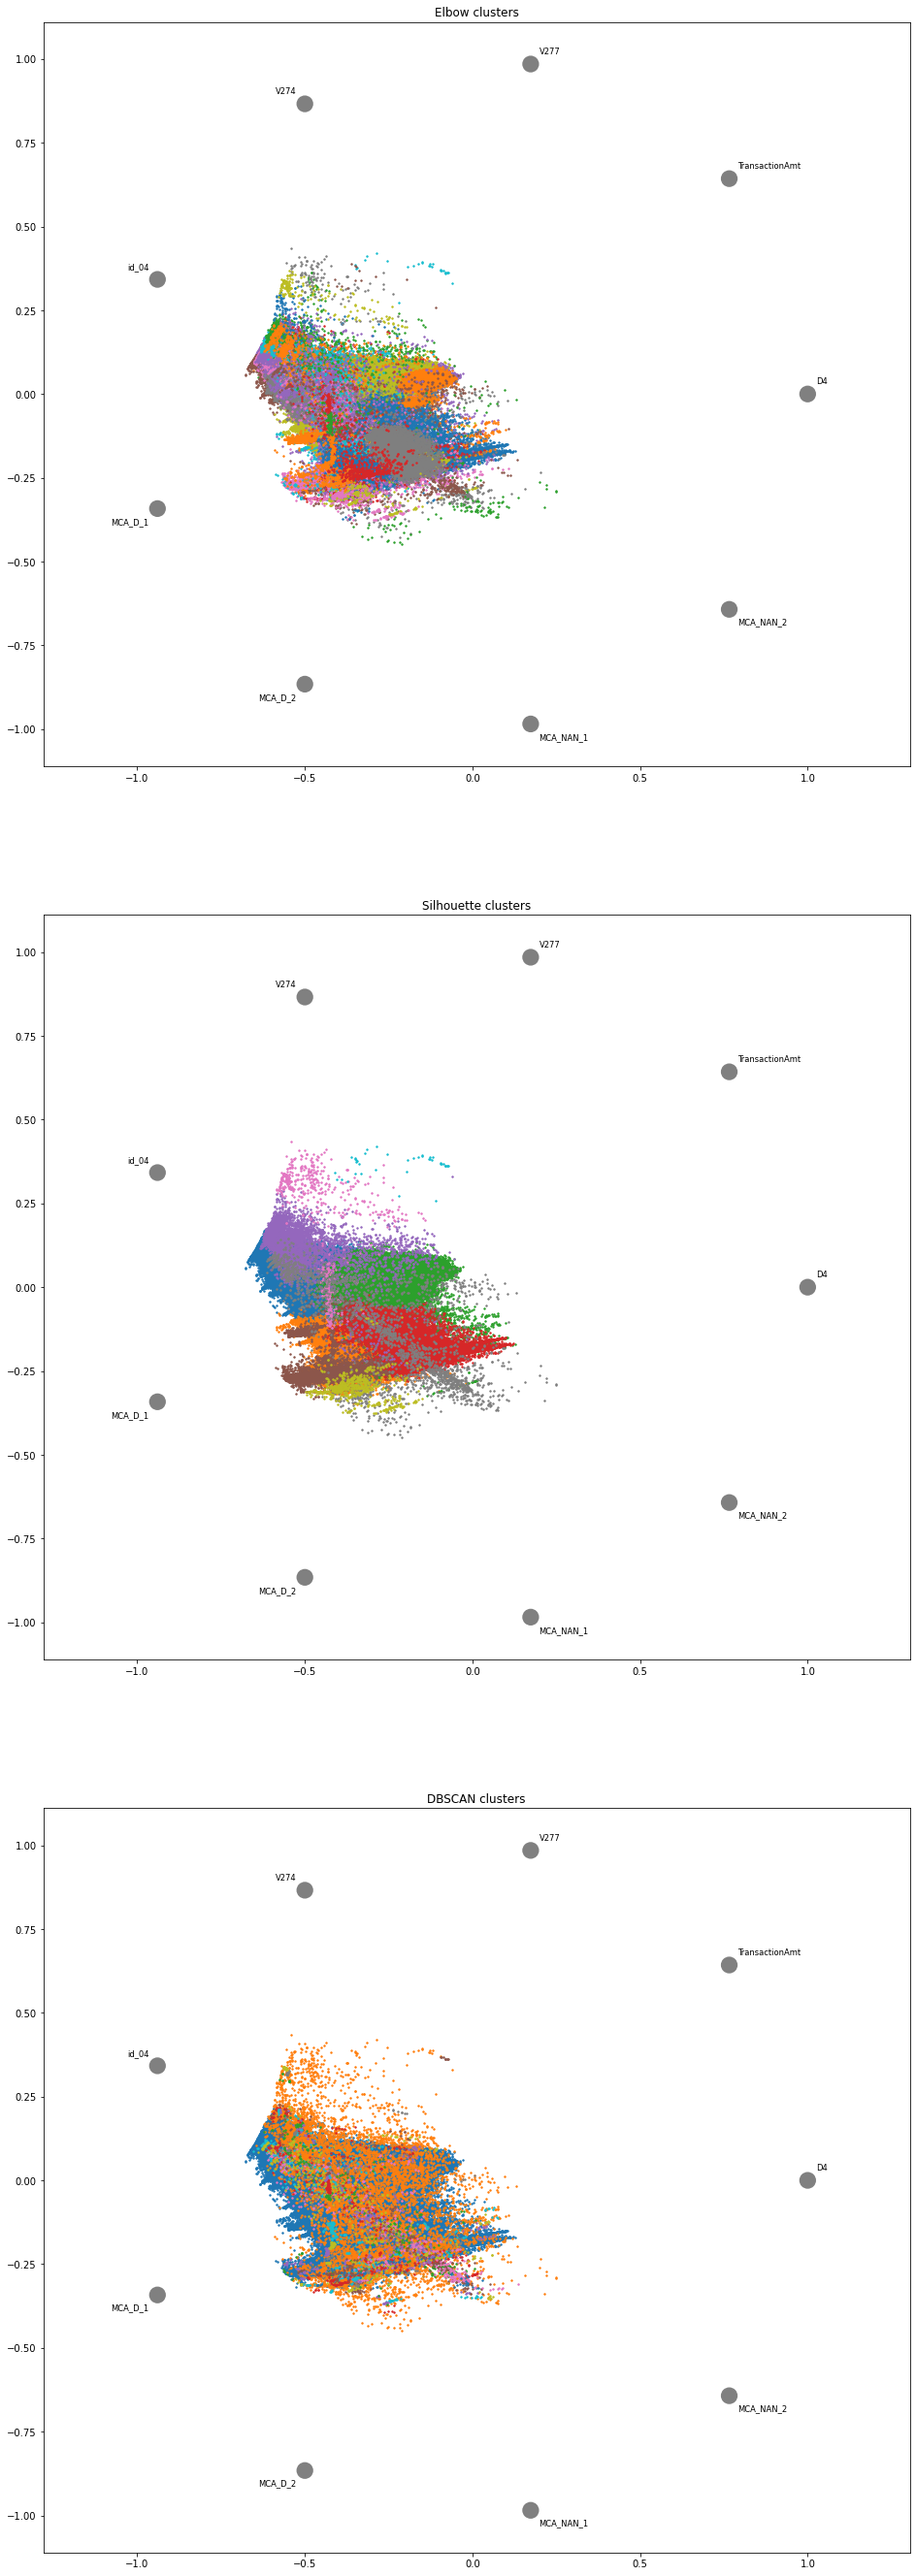

In [46]:
fig, axis = plt.subplots(3, 1, figsize=(16, 48))
axs = axis.flatten()

pd.plotting.radviz(frame=clustered_df.drop(['isFraud', 'dbscan', 'silhouette'], axis=1), class_column='elbow', color=sns.color_palette(), s=2, ax=axs[0])
axs[0].set_title('Elbow clusters')
pd.plotting.radviz(frame=clustered_df.drop(['isFraud', 'elbow', 'dbscan'], axis=1), class_column='silhouette', color=sns.color_palette(), s=2, ax=axs[1])
axs[1].set_title('Silhouette clusters')
pd.plotting.radviz(frame=clustered_df.drop(['isFraud', 'elbow', 'silhouette'], axis=1), class_column='dbscan', color=sns.color_palette(), s=2, ax=axs[2])
axs[2].set_title('DBSCAN clusters')

axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()

plt.show()

**Заключение**

В "боевой обстановке" эта работа ни о чем. Поскольку слишком много слишком смелых предположений и нет сравнений. И я больше времени потратил на расчеты, чем на эксперименты. Но не изза моей лени - очень долго всё считается. Я просто не в состоянии потратить еще 10-15 часов на расчеты.

Тем не менее, некоторые выводы я могу сделать.

**Выводы**

1. Стандартизация необходима для любых алгоритмов на основе расстояния. Точнее, без нее всё что на соседях просто не считается, а что считается непонятно на что похоже

2. Кластеризацию я вижу как часть большого пайплайна. Как отдельный инструмент я бы её не стал применять для решения важных задач "в одно лицо".

3. Кластеризация, как по мне, отличный вспомогательный инструмент. В тойже классификации "cluster as a feature" работает отлично.

4. Метрики оценки кластеризации весьма условны. Без эксперта непонятно, на самом деле, правильно проведена кластеризация или нет.